# Unsupervised Learning for Clustering NBA Players:
---
## Clustering & Visualization
Clustering and visualization are very useful in tandem. As opposed to a regression or classification problem, unsupervised learning for clustering can sometimes be relatively opaque in terms of how well they've achieved their task. I don't anticipate fantastic silhouette scores straight off the bat so we most likely will need to use a few visualization techniques to help us out.

Remy Shea, May 2019, https://github.com/RemShea/nba-player-clustering

---
# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, MiniBatchKMeans
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline


---
# Read In Data

In [2]:
X_sc = pd.read_csv('../data/players_feat_eng_scaled.csv',index_col='name')

In [3]:
X_sc.head()

,astd_pts,avg_dist,fg2_dunk,fg2_pct,fg3_pct_corner,fg3_per_g,fg_pct,ft_per_g,fta_per_fga_pct,own_shots_blk,...,finish_through_contact,shot_distribution,charge_draw_rate,assist_turnover_ratio,shot_selection,iso_effectiveness,off_def_rebound,efficient_shot_taker,ft_pct,net_offensive_bpm
name,,,,,,,,,,,,,,,,,,,,,
Klay Thompson,-0.549724,0.942183,-0.436166,0.017973,0.818642,1.675451,0.106353,-0.469764,-1.197722,-0.533053,...,-1.187949,-0.662541,-0.322537,-0.162812,0.628187,0.129036,-0.897441,0.929857,0.816,1.303065
Draymond Green,2.122174,0.007430,-0.302059,0.541569,0.778691,-0.840434,-0.236761,-0.925390,-0.304867,-1.254653,...,0.883011,-0.318644,0.335981,-0.224019,-0.250314,-1.010084,-0.938650,-0.951724,0.692,-1.687437
Jordan Bell,-0.021584,-1.144707,0.948416,0.097306,0.000000,-1.658105,0.870561,-0.861433,-0.322204,-0.651404,...,-0.080965,-0.109358,1.482363,0.352250,-1.131223,-1.176917,0.857484,-1.315577,0.610,-2.098631
Stephen Curry,0.960682,1.376952,-0.814379,0.160772,1.274076,3.858584,0.184333,1.105926,-0.322204,-0.495021,...,0.538685,0.699757,0.459743,-0.495788,-0.381441,0.507325,-0.885417,1.098567,0.916,3.508560
Andre Iguodala,0.650842,0.333507,1.085170,2.175824,0.395168,-0.554954,0.621024,-1.079027,-0.252856,-1.854811,...,-0.008092,0.203133,0.127544,1.408756,-0.980293,-0.052641,-0.344855,0.685144,0.582,-0.453855


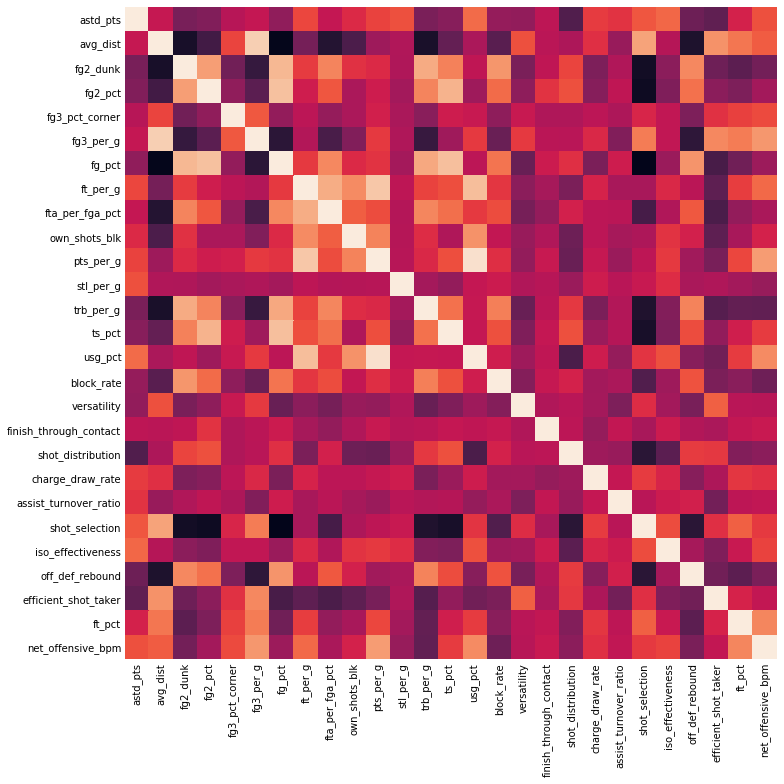

In [37]:
plt.figure(figsize=(12,12))
sns.heatmap(X_sc.corr(),square=True,cbar=False)
plt.savefig('../assets/feat_eng_heatmap.png',dpi=500)

---
# Define Functions
This is a handy little function for performing a PCA, as well as plotting charts for relative variance explained and cumulative variance explained.

In [5]:
def pca_plot(data,display=False,plot=False):
    """Returns a PCA object"""
    
    pca=PCA()
    data_pca = pd.DataFrame(pca.fit_transform(data))
    data_pca.columns = [f'PC{i+1}' for i in data_pca.columns]

    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    
    if plot:
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

        component_number = range(len(var_exp))
        ax1.plot(component_number, var_exp, lw=3,zorder=1)
        ax1.scatter(component_number, var_exp, s=60, c='k',zorder=2)
        ax1.scatter(component_number, var_exp, s=20, c='w',zorder=3)
        ax1.set_xlim([-1,15])
        ax1.set_ylim([-0.05,1.05])
        ax1.set_ylabel('variance explained (%)', fontsize=16)
        ax1.set_xlabel('principal component number', fontsize=16)
        for tick in ax1.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
        for tick in ax1.yaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
        ax1.set_title('Component vs Variance Explained\n', fontsize=20)

        component_number = range(len(cum_var_exp))
        ax2.plot(component_number, cum_var_exp, lw=3,zorder=1)
        ax2.scatter(component_number, cum_var_exp, s=60, c='k',zorder=2)
        ax2.scatter(component_number, cum_var_exp, s=20, c='w',zorder=3)
        ax2.set_xlim([-1,15])
        ax2.set_ylim([-0.05,1.05])
        ax2.set_ylabel('cumulative variance explained (%)', fontsize=16)
        ax2.set_xlabel('principal component number', fontsize=16)
        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
        ax2.set_title('Component vs Cumulative Variance Explained\n', fontsize=20)

        plt.show()
        
    if display:
        print(f'Explained variance:\t|\tCumulative explained variance:')
        for i in range(data_pca.shape[1]):
            print(f'\t{np.round(var_exp[i],3)}\t\t|\t{np.round(cum_var_exp[i],3)}')
    return data_pca

In [6]:
def eye_test(data,labels,group,sub_sample=False):
    temp=data
    temp['label'] = labels
    temp = temp[temp['label']==group]
    if sub_sample==False:
        return temp
    else:
        sample = np.random.choice(temp.index,size=sub_sample,replace=False)
        return temp.loc[sample]

# Unprocessed Data
We could simply perform clustering on the raw data that we gathered from the basketball-reference.com website. This would negate all the steps taken in `feature_engineering.ipynb`. Let's take a look

In [7]:
X = pd.read_csv('../data/players.csv',index_col='name')

In [8]:
X.head()

,and1s,ast_pct,ast_per_g,astd_pts,avg_dist,blk_pct,blk_per_g,bpm,dbpm,drawn_offensive,...,tov_bad_pass,tov_lost_ball,tov_pct,tov_per_g,trb_pct,trb_per_g,ts_pct,usg_pct,assist_turnover_ratio,label
name,,,,,,,,,,,,,,,,,,,,,
Klay Thompson,0.135747,10.5,2.541176,5.714932,17.7,1.5,0.635294,-0.8,-2.0,0.135747,...,0.692308,0.420814,7.2,1.588235,6.0,4.023529,0.571,25.6,-0.278887,6
Draymond Green,0.209201,26.8,7.936102,18.636320,13.4,2.8,1.265176,2.0,3.4,0.383535,...,2.214044,0.331235,26.8,2.990415,12.4,8.396166,0.526,13.1,1.024187,5
Jordan Bell,0.182741,12.3,3.413793,8.269036,8.1,5.4,2.482759,-0.4,2.8,0.411168,...,0.776650,0.548223,16.7,1.862069,12.5,8.379310,0.531,13.7,0.009628,2
Stephen Curry,0.478764,24.2,5.538462,13.019305,19.7,0.9,0.426036,6.3,-1.4,0.355212,...,1.729730,0.772201,11.6,2.982249,8.4,5.644970,0.641,30.4,0.039068,4
Andre Iguodala,0.159696,16.8,4.965517,11.520913,14.9,2.7,1.241379,1.9,1.7,0.228137,...,0.844106,0.136882,13.6,1.241379,8.5,5.741379,0.587,10.4,2.688697,3


In [126]:
scores=[]
for i in range(3,25):
    clf = KMeans(n_clusters=i).fit(X)
    score = silhouette_score(X,clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 3 clusters achieved silhouette score:
0.4679833669161639

KMeans Clustering with 4 clusters achieved silhouette score:
0.5241988115221939

KMeans Clustering with 5 clusters achieved silhouette score:
0.5676149742927492

KMeans Clustering with 6 clusters achieved silhouette score:
0.5470906222687643

KMeans Clustering with 7 clusters achieved silhouette score:
0.5055750417295779

KMeans Clustering with 8 clusters achieved silhouette score:
0.4878724612392556

KMeans Clustering with 9 clusters achieved silhouette score:
0.4724621061251116

KMeans Clustering with 10 clusters achieved silhouette score:
0.45399310595924475

KMeans Clustering with 11 clusters achieved silhouette score:
0.4174375406362285

KMeans Clustering with 12 clusters achieved silhouette score:
0.39772106062440393

KMeans Clustering with 13 clusters achieved silhouette score:
0.38412501965913814

KMeans Clustering with 14 clusters achieved silhouette score:
0.331049463930303

KMeans Clustering wit

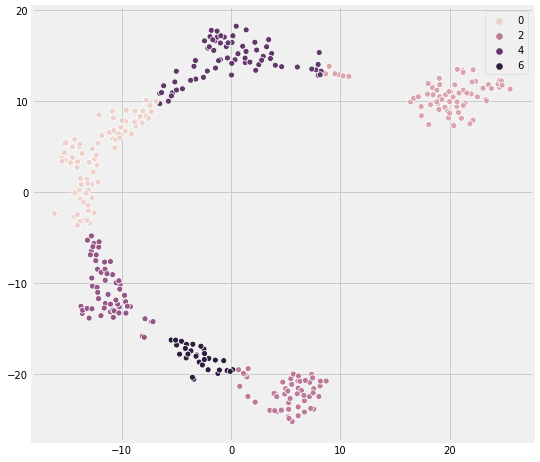

In [120]:
_,_,clf = scores[3]
clf_tsne=TSNE().fit_transform(X)
plt.figure(figsize=(8,8))
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_)

This looks a little bit weird, but that's moreso the way that t-SNE generates the graphs. The silhouette scores are certainly not bad. 

The problem with this, however, is that as mentioned in the `README.md` some of the stats included in this analysis are ones that aren't so much related to the individual player's playing style, which is what we are concerned with. 

We want to identify the types of players in the NBA and using metrics heavily influenced by team performnance, personal skill, etc. can get in the way of establishing that. That being said, it might be that there is not much benefit gleamed from removing these components.

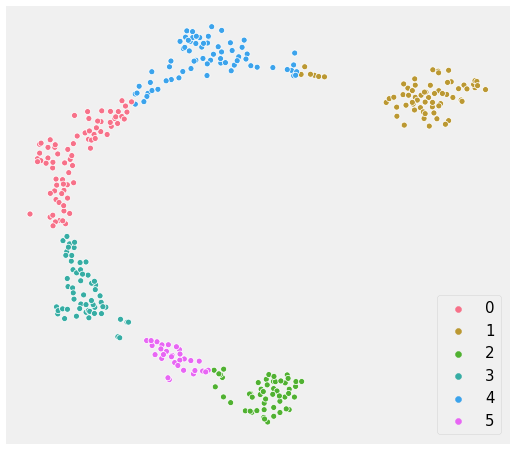

In [125]:
fig,ax = plt.subplots(1,figsize=(8,8))
palette = sns.color_palette("husl", 6)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_,palette=palette)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc=4, prop={'size': 15})
plt.savefig('../assets/raw_data_cluster.png',dpi=500)

---
# Feature Selection
A general heuristic for the number of features suitable for an analysis is the square root of the number of the observations. We have about 354 datapoints, so our analysis should at an absolute maximum contain maybe 18 features.

In [12]:
X_sc.shape[1]

27

We've got down to 27 features from the 81 originally gathered. That's not bad, but we need to drop maybe another half to be safe.

### No Feature Selection
It may be entirely possible that the features as they are right now produce good clustering scores.

In [13]:
scores=[]
for i in range(3,10):
    clf = KMeans(n_clusters=i).fit(X_sc)
    score = silhouette_score(X_sc,clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 3 clusters achieved silhouette score:
0.15663962893427075

KMeans Clustering with 4 clusters achieved silhouette score:
0.12815037034959628

KMeans Clustering with 5 clusters achieved silhouette score:
0.11666886017484082

KMeans Clustering with 6 clusters achieved silhouette score:
0.10145414049226711

KMeans Clustering with 7 clusters achieved silhouette score:
0.1013946816632361

KMeans Clustering with 8 clusters achieved silhouette score:
0.09369740256930052

KMeans Clustering with 9 clusters achieved silhouette score:
0.09065883720674542



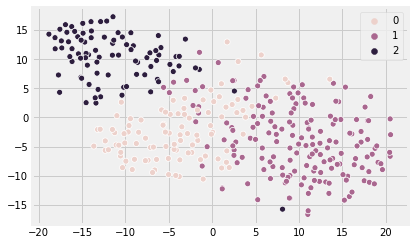

In [14]:
_,_,clf = scores[0]
clf_tsne=TSNE().fit_transform(X_sc)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_)

This is not likely the case.

### Variance Inflation Factor
The variance inflation factor is a measure of how well a feature is explained by the other features in a dataset. A low variance inflation factor means this feature is more orthogonal to the other features in this dataset.

In [45]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values('VIF',ascending=False).head(10)

,VIF,features
27,inf,fg3a_per_fga_pct
26,inf,fg3a_pct_fga
18,1.228699e+06,fg2a_pct_fga
53,3.184417e+05,pct_fga_00_03
13,1.421711e+05,efg_pct
29,1.036312e+05,fg_pct
54,8.601442e+04,pct_fga_03_10
35,3.613340e+04,fga_per_g
67,3.249413e+04,ts_pct
55,2.887261e+04,pct_fga_10_16


These numbers are, as expected, pretty dang large in the original dataset where multicollinearity is pervasive.

In [53]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_sc.values, i) for i in range(X_sc.shape[1])]
vif["features"] = X_sc.columns
vif.sort_values('VIF',ascending=False).head(10)

,VIF,features
10,123.966097,pts_per_g
14,82.753929,usg_pct
6,68.338813,fg_pct
7,31.632734,ft_per_g
13,31.331972,ts_pct
1,30.331166,avg_dist
5,19.966155,fg3_per_g
21,12.361505,shot_selection
8,10.817946,fta_per_fga_pct
26,9.924090,net_offensive_bpm


In [16]:
low_variance_variables = vif.sort_values('VIF',ascending=True)['features'][:10]
low_variance_variables

25                    ft_pct
17    finish_through_contact
19          charge_draw_rate
4             fg3_pct_corner
16               versatility
11                 stl_per_g
20     assist_turnover_ratio
22         iso_effectiveness
15                block_rate
23           off_def_rebound
Name: features, dtype: object

In [17]:
scores=[]
for i in range(3,10):
    clf = KMeans(n_clusters=i).fit(X_sc[low_variance_variables])
    score = silhouette_score(X_sc[low_variance_variables],clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 3 clusters achieved silhouette score:
0.134941946021056

KMeans Clustering with 4 clusters achieved silhouette score:
0.13639338286813457

KMeans Clustering with 5 clusters achieved silhouette score:
0.13119243105710895

KMeans Clustering with 6 clusters achieved silhouette score:
0.13487554940100652

KMeans Clustering with 7 clusters achieved silhouette score:
0.12731134411336456

KMeans Clustering with 8 clusters achieved silhouette score:
0.11201342879154544

KMeans Clustering with 9 clusters achieved silhouette score:
0.129622482047111



This seems to perform better than the naive clustering. Although, the silhouette scores really aren't so great in absolute terms.

Just to contrast, below is an analysis repeated using the terms with the highest Varaince Inflation Factors.

In [18]:
high_variance_variables = vif.sort_values('VIF',ascending=False)['features'][:10]
scores=[]
for i in range(3,10):
    clf = KMeans(n_clusters=i).fit(X_sc[high_variance_variables])
    score = silhouette_score(X_sc[high_variance_variables],clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 3 clusters achieved silhouette score:
0.31351740071497647

KMeans Clustering with 4 clusters achieved silhouette score:
0.23198369534258456

KMeans Clustering with 5 clusters achieved silhouette score:
0.20849328401701434

KMeans Clustering with 6 clusters achieved silhouette score:
0.22659416413872857

KMeans Clustering with 7 clusters achieved silhouette score:
0.22055457287006344

KMeans Clustering with 8 clusters achieved silhouette score:
0.21379923372103635

KMeans Clustering with 9 clusters achieved silhouette score:
0.20443729618228515



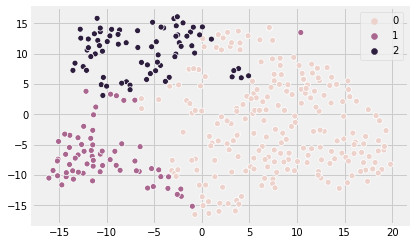

In [19]:
_,_,clf = scores[0]
clf_tsne = TSNE().fit_transform(X_sc[high_variance_variables])
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_)

Interesting that the higher variance features yield 'better' clusters. Although admittedly these aren't exactly very distinct clusters.

In [20]:
eye_test(X_sc,clf.labels_,2,10)

,astd_pts,avg_dist,fg2_dunk,fg2_pct,fg3_pct_corner,fg3_per_g,fg_pct,ft_per_g,fta_per_fga_pct,own_shots_blk,...,shot_distribution,charge_draw_rate,assist_turnover_ratio,shot_selection,iso_effectiveness,off_def_rebound,efficient_shot_taker,ft_pct,net_offensive_bpm,label
name,,,,,,,,,,,,,,,,,,,,,
Harrison Barnes,-0.888013,0.333507,-0.348232,-1.203751,0.738741,0.897872,-0.626663,0.569793,0.171901,-0.084146,...,-0.596443,0.135002,-0.553103,0.756642,0.483695,-0.689738,1.152913,0.824,0.555439,2
Allonzo Trier,-0.272233,-0.253431,-0.592639,-0.775355,-0.196098,-0.375242,-0.189973,1.367951,1.558861,2.354388,...,-0.825275,0.951171,-1.109487,0.118642,0.628993,-0.607623,-0.808510,0.803,0.032101,2
Kawhi Leonard,0.096724,-0.014308,0.328125,0.430504,0.499039,0.385043,0.558640,2.796706,1.090762,0.408292,...,-1.412382,-0.302945,0.500820,0.497826,0.820890,-0.451605,-0.245198,0.854,1.452590,2
Buddy Hield,-0.356508,0.790014,-0.262777,-0.442157,1.266086,2.238741,-0.034012,-0.070182,-0.946336,0.053363,...,-0.336077,-0.373934,-0.690635,0.195795,0.256778,0.411048,0.965685,0.886,2.013309,2
Malcolm Brogdon,0.300228,-0.557769,-0.689514,0.462237,1.138245,0.387298,0.699004,0.209799,-0.417557,1.328025,...,0.274146,-0.526614,0.141978,-1.089639,0.815274,-0.009356,-0.212288,0.928,0.929252,2
DeMarcus Cousins,0.730598,-0.709938,0.475571,0.573303,-2.856792,-0.377738,0.309102,1.705668,1.186115,2.250073,...,-0.343194,1.758719,0.180533,-0.582568,-0.422866,-0.520678,-1.231706,0.736,-1.089337,2
Bojan Bogdanovic,-0.629167,0.029169,-0.304618,0.367037,1.098294,0.641366,0.574236,0.649408,0.336602,1.480786,...,-0.762868,-0.455723,-0.854479,-0.086758,0.071761,-1.146920,0.729005,0.807,1.153540,2
Frank Kaminsky,-0.252500,0.290030,-0.600764,0.605036,-2.129696,0.839892,0.043969,0.933380,0.934729,-0.447617,...,-0.073658,0.535276,0.838708,-0.001752,-1.534881,0.131413,-0.810374,0.738,1.228302,2
Jrue Holiday,1.978199,-0.231692,-0.376578,0.382904,0.419138,0.175067,0.184333,0.447768,-0.148834,0.728635,...,-0.902696,-0.487330,-0.137355,0.184318,0.872820,-0.032817,-0.721806,0.768,1.228302,2


The second cluster seems to be mostly traditional centers, with limited shooting ability. Ironic.

### Principal Componene Analysis for Feature Selection
The purpose of PCA is to find lower-dimensional representations of the dataset. One idea is to use the features which factored most heavily into the PCA's eigenvectors as features for a clustering algorithm. (Veronica helped me with this one).

In [21]:
pca=PCA()
pca_df=pca.fit_transform(X_sc)

In [22]:
pc_weights = pd.DataFrame(pca.components_[:3],columns=X_sc.columns).T
pc_weights['total'] = np.abs(pc_weights[0])+np.abs(pc_weights[1])+np.abs(pc_weights[2])

print(pc_weights.sort_values('total',ascending=False))

                               0         1         2     total
fg3_per_g              -0.253503  0.096428  0.369127  0.719058
net_offensive_bpm      -0.093283  0.291705  0.311848  0.696836
pts_per_g               0.080003  0.392325  0.216817  0.689145
efficient_shot_taker   -0.189860 -0.176507  0.297713  0.664080
ts_pct                  0.235383  0.019347  0.365423  0.620153
shot_distribution       0.095743 -0.252950  0.265420  0.614112
ft_per_g                0.134060  0.364743  0.102578  0.601380
shot_selection         -0.302648  0.144971 -0.153706  0.601325
astd_pts               -0.069337  0.272349 -0.229504  0.571189
avg_dist               -0.317110 -0.015297  0.219153  0.551559
fg2_pct                 0.267421 -0.079653  0.193697  0.540772
usg_pct                 0.023432  0.416732  0.089155  0.529319
own_shots_blk           0.106924  0.269797 -0.118665  0.495387
iso_effectiveness      -0.058821  0.222539 -0.209981  0.491341
label                   0.112491  0.256886  0.076639  0

In [23]:
a = list(pd.Series(pca.components_[0],index=X_sc.columns,name='PC1_weights').sort_values(ascending=False)[:5].index.values)

b = list(pd.Series(pca.components_[1],index=X_sc.columns,name='PC1_weights').sort_values(ascending=False)[:5].index.values)

c = list(pd.Series(pca.components_[2],index=X_sc.columns,name='PC1_weights').sort_values(ascending=False)[:5].index.values)
myset = set()
for item in a:
    myset.add(item)
for item in b:
    myset.add(item)
for item in c:
    myset.add(item)
test = X_sc[myset]
test.head()

,fg2_dunk,pts_per_g,ft_per_g,fg3_per_g,net_offensive_bpm,fg2_pct,ts_pct,usg_pct,efficient_shot_taker,fg_pct,astd_pts,fta_per_fga_pct,trb_per_g,shot_distribution
name,,,,,,,,,,,,,,
Klay Thompson,-0.436166,1.454480,-0.469764,1.675451,1.303065,0.017973,0.320951,1.214041,0.929857,0.106353,-0.549724,-1.197722,-0.882373,-0.662541
Draymond Green,-0.302059,-1.565494,-0.925390,-0.840434,-1.687437,0.541569,-0.630612,-1.161957,-0.951724,-0.236761,2.122174,-0.304867,0.518170,-0.318644
Jordan Bell,0.948416,-1.198907,-0.861433,-1.658105,-2.098631,0.097306,-0.524883,-1.047909,-1.315577,0.870561,-0.021584,-0.322204,0.512771,-0.109358
Stephen Curry,-0.814379,2.791885,1.105926,3.858584,3.508560,0.160772,1.801161,2.126424,1.098567,0.184333,0.960682,-0.322204,-0.363030,0.699757
Andre Iguodala,1.085170,-1.494802,-1.079027,-0.554954,-0.453855,2.175824,0.659285,-1.675172,0.685144,0.621024,0.650842,-0.252856,-0.332151,0.203133


### Principal Component Analysis for Clustering
The principal components themselves may make for a good basis of clustering algorithms.

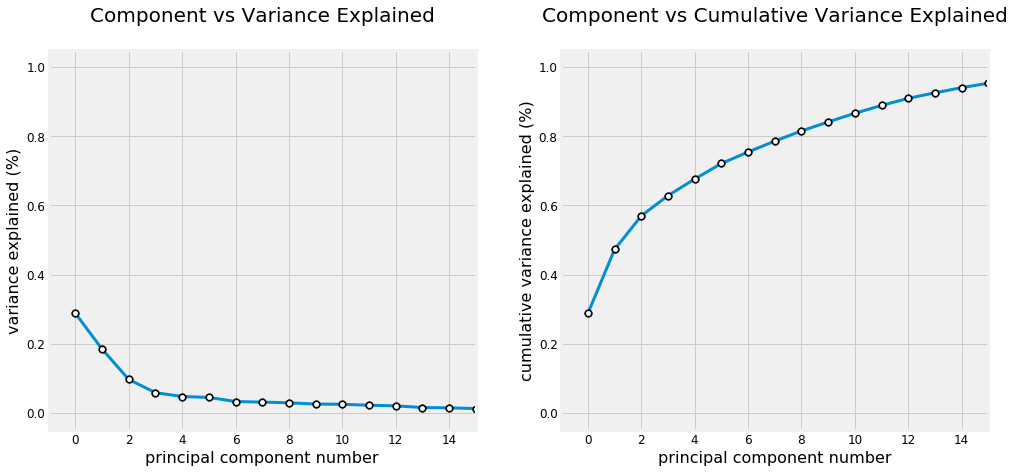

Explained variance:	|	Cumulative explained variance:
	0.288		|	0.288
	0.185		|	0.473
	0.097		|	0.57
	0.059		|	0.629
	0.048		|	0.676
	0.045		|	0.721
	0.033		|	0.754
	0.032		|	0.786
	0.029		|	0.815
	0.026		|	0.841
	0.025		|	0.867
	0.022		|	0.889
	0.021		|	0.91
	0.016		|	0.926
	0.015		|	0.94
	0.013		|	0.953
	0.01		|	0.964
	0.009		|	0.972
	0.008		|	0.98
	0.006		|	0.986
	0.005		|	0.991
	0.003		|	0.994
	0.002		|	0.996
	0.002		|	0.999
	0.001		|	0.999
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0


In [24]:
pca = pca_plot(X_sc,True,True)

In [105]:
scores=[]
for i in range(2,10):
    clf = KMeans(n_clusters=i).fit(pca)
    score = silhouette_score(pca,clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 2 clusters achieved silhouette score:
0.23877048917025187

KMeans Clustering with 3 clusters achieved silhouette score:
0.19069434847072822

KMeans Clustering with 4 clusters achieved silhouette score:
0.14126542329818573

KMeans Clustering with 5 clusters achieved silhouette score:
0.1248997386329946

KMeans Clustering with 6 clusters achieved silhouette score:
0.12489176950239768

KMeans Clustering with 7 clusters achieved silhouette score:
0.10914712998642051

KMeans Clustering with 8 clusters achieved silhouette score:
0.10377394538108098

KMeans Clustering with 9 clusters achieved silhouette score:
0.09109555957312304



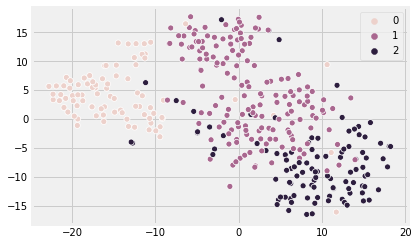

In [116]:
_,_,clf = scores[1]
clf_tsne = TSNE().fit_transform(pca)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_)

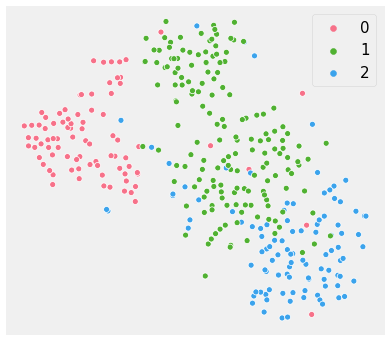

In [117]:
fig,ax = plt.subplots(1,figsize=(6,6))
palette = sns.color_palette("husl", 3)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_,palette=palette)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc=1, prop={'size': 15})
plt.savefig('../assets/feat_eng_tsne.png',dpi=300)

In all honesty, this is pretty bad. It might be that some of the features removed previously were important in separating classes.

### Manual Feature Selection
Using 'domain knowledge', can a feature set be hand-picked to produce good clusters?

In [27]:
X_sc.drop(['label'],axis=1,inplace=True)

In [28]:
X_sc.columns

Index(['astd_pts', 'avg_dist', 'fg2_dunk', 'fg2_pct', 'fg3_pct_corner',
       'fg3_per_g', 'fg_pct', 'ft_per_g', 'fta_per_fga_pct', 'own_shots_blk',
       'pts_per_g', 'stl_per_g', 'trb_per_g', 'ts_pct', 'usg_pct',
       'block_rate', 'versatility', 'finish_through_contact',
       'shot_distribution', 'charge_draw_rate', 'assist_turnover_ratio',
       'shot_selection', 'iso_effectiveness', 'off_def_rebound',
       'efficient_shot_taker', 'ft_pct', 'net_offensive_bpm'],
      dtype='object')

In [97]:
manual = X_sc[[
    'block_rate', 'versatility', 'finish_through_contact',
       'shot_distribution', 'charge_draw_rate', 'assist_turnover_ratio',
       'shot_selection', 'iso_effectiveness', 'off_def_rebound',
       'efficient_shot_taker', 'net_offensive_bpm'
]]

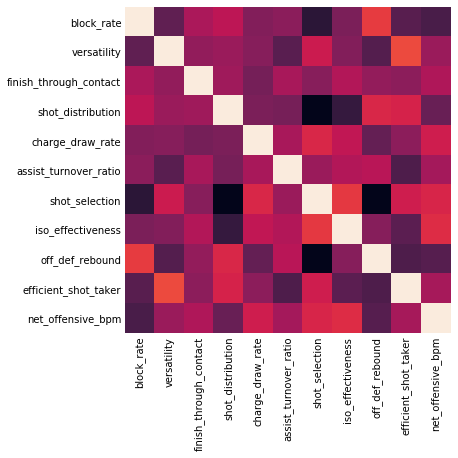

In [98]:
plt.figure(figsize=(6,6))
sns.heatmap(manual.corr(),square=True,cbar=False)
# plt.savefig('../assets/manual_corr_heatmap.png',dpi=500)

In [99]:
print(f'Mean Pairwise Correlation of Hand-Crafted Features: {round(np.mean(np.mean(manual.corr())),4)}, Standard Deviation of {round(np.std(np.std(manual.corr())),4)}')
print(f'Mean Pairwise Correlation of All Features: {round(np.mean(np.mean(X_sc.corr())),4)}, Standard Deviation of {round(np.std(np.std(X_sc.corr())),4)}')
print(f'Mean Pairwise Correlation of Original Dataset: {round(np.mean(np.mean(X.corr())),4)}, Standard Deviation of {round(np.std(np.std(X.corr())),4)}')


Mean Pairwise Correlation of Hand-Crafted Features: 0.0608, Standard Deviation of 0.043
Mean Pairwise Correlation of All Features: 0.0682, Standard Deviation of 0.0831
Mean Pairwise Correlation of Original Dataset: 0.0861, Standard Deviation of 0.0877


The hand-crafted feature set has relatively low pairwise autocorrelation.

In [109]:
scores=[]
for i in range(2,30):
    clf = KMeans(n_clusters=i).fit(manual)
    score = silhouette_score(manual,clf.labels_)
    print(f'KMeans Clustering with {i} clusters achieved silhouette score:\n{score}\n')
    scores.append((i,score,clf))

KMeans Clustering with 2 clusters achieved silhouette score:
0.19805520863239742

KMeans Clustering with 3 clusters achieved silhouette score:
0.1649746598800973

KMeans Clustering with 4 clusters achieved silhouette score:
0.1389258858344848

KMeans Clustering with 5 clusters achieved silhouette score:
0.120296020263184

KMeans Clustering with 6 clusters achieved silhouette score:
0.12068656412089779

KMeans Clustering with 7 clusters achieved silhouette score:
0.12367031033514107

KMeans Clustering with 8 clusters achieved silhouette score:
0.12067160807763787

KMeans Clustering with 9 clusters achieved silhouette score:
0.11479060356215692

KMeans Clustering with 10 clusters achieved silhouette score:
0.1254813393646064

KMeans Clustering with 11 clusters achieved silhouette score:
0.11336903916386465

KMeans Clustering with 12 clusters achieved silhouette score:
0.10910099304396273

KMeans Clustering with 13 clusters achieved silhouette score:
0.11249550562377046

KMeans Clustering

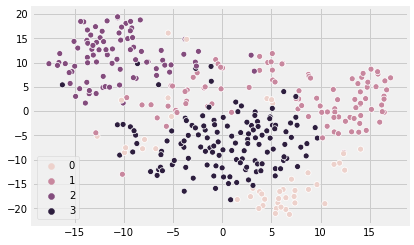

In [112]:
_,_,clf = scores[2]
clf_tsne = TSNE().fit_transform(manual)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_)

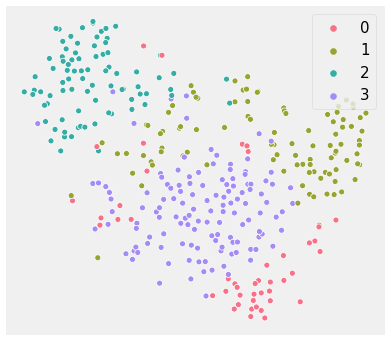

In [113]:
fig,ax = plt.subplots(1,figsize=(6,6))
palette = sns.color_palette("husl", 4)
sns.scatterplot(clf_tsne[:,0],clf_tsne[:,1],hue=clf.labels_,palette=palette)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc=1, prop={'size': 15})
plt.savefig('../assets/manual_tsne.png',dpi=300)

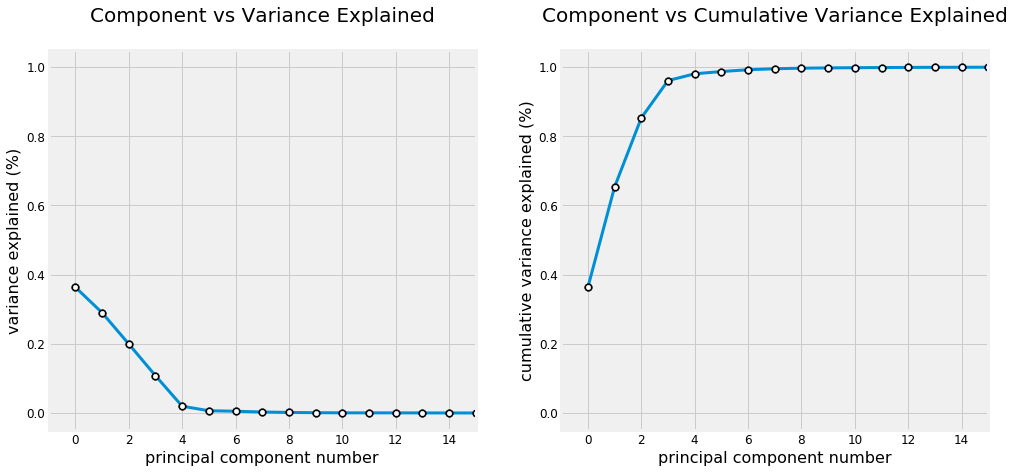

Explained variance:	|	Cumulative explained variance:
	0.364		|	0.364
	0.29		|	0.654
	0.2		|	0.853
	0.108		|	0.961
	0.02		|	0.981
	0.007		|	0.987
	0.005		|	0.992
	0.003		|	0.995
	0.002		|	0.997
	0.001		|	0.998
	0.001		|	0.998
	0.0		|	0.999
	0.0		|	0.999
	0.0		|	0.999
	0.0		|	0.999
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0
	0.0		|	1.0


In [34]:
full_pca=pca_plot(X,True,True)

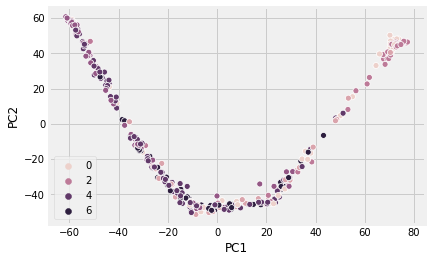

In [35]:
sns.scatterplot(full_pca['PC1'],full_pca['PC2'],hue=clf.labels_)

As we can see, the manually selected, engineered features perform better than analyses using the engineered features, and the other features from the original dataset that were not included in the analysis. This is encouraging, since these features are highly interpretable, and have low correlation amongst themselves and with other features, as demonstrated by the pairwise correlation heatmaps shown just above and at the top of the notebook. Finally, the labels predicted using the hand-crafted features are not completely terrible when mapping onto the first two principal components of the original, unedited dataset. That being said, the silhouette score are still not fantastic.